In [1]:
# try to find the exact values for composer/buythedips-nasdaq/shorting-adapted/buythedipsnasdaq.py

# implemented in: composer/buythedips-nasdaq/shorting-explored/buythedipsnasdaq.py

In [3]:
from datetime import datetime, timedelta

# adapted to to buy tqqq if 5 day qqq return positive, else short qqq with sqqq
from basebot22.basebot import BaseBot

# basic setup
bot = BaseBot("testbot") # backendurl = "http://tradingbot-baseimage-service:8000"


In [12]:
STOCKS = ["QQQ", "TQQQ", "SQQQ"]
datas = dict()
for ticker in STOCKS:
    datas[ticker] = bot.getData(ticker, start_date = datetime.now() - timedelta(days=3*12*365))
    datas[ticker]["cumulative_5d_return"] = datas[ticker]["adj_close"].pct_change(5).cumsum()
    datas[ticker]["cumulative_1d_return"] = datas[ticker]["adj_close"].pct_change(1).cumsum()
    datas[ticker]["pct_change"] = datas[ticker]["adj_close"].pct_change(1)
datas["TQQQ"].head()

,high,close,adj_close,low,ticker,open,volume,cumulative_5d_return,cumulative_1d_return,pct_change
timestamp,,,,,,,,,,
2018-01-02,12.178333,12.153333,12.065624,11.657500,TQQQ,11.741667,45867600,NaN,NaN,NaN
2018-01-03,12.555000,12.509167,12.418888,12.200833,TQQQ,12.202500,42612000,NaN,0.029279,0.029279
2018-01-04,12.700833,12.582500,12.491693,12.538333,TQQQ,12.655833,35012400,NaN,0.035141,0.005862
2018-01-05,12.990000,12.962500,12.868951,12.692500,TQQQ,12.758333,41190000,NaN,0.065342,0.030201
2018-01-08,13.133333,13.106667,13.012076,12.948333,TQQQ,12.960833,36126000,NaN,0.076463,0.011122


In [13]:
datas["TQQQ"].tail()

,high,close,adj_close,low,ticker,open,volume,cumulative_5d_return,cumulative_1d_return,pct_change
timestamp,,,,,,,,,,
2022-12-23,17.719999,17.590000,17.590000,16.830000,TQQQ,17.209999,165067300,8.122609,1.895785,0.002851
2022-12-27,17.480000,16.840000,16.840000,16.719999,TQQQ,17.459999,131600300,8.044338,1.853147,-0.042638
2022-12-28,17.200001,16.160000,16.160000,16.100000,TQQQ,16.750000,182434600,7.932739,1.812767,-0.040380
2022-12-29,17.500000,17.299999,17.299999,16.530001,TQQQ,16.670000,153054900,7.844224,1.883312,0.070545
2022-12-30,17.299999,17.299999,17.299999,16.500000,TQQQ,16.760000,150368500,7.830541,1.883312,0.000000


In [18]:
for ticker in STOCKS:
    print(ticker, datas[ticker].shape)

QQQ (1259, 10)
TQQQ (1259, 10)
SQQQ (1259, 10)


In [44]:
## logic
def simulateOne(qqq5d_threshold = -0.05, lookback = 5):
    money = 10000
    stocks = { "SQQQ" : 0, "TQQQ" : 0}
    datas["QQQ"]["cumulative_5d_return"] = datas["QQQ"]["adj_close"].pct_change(lookback).cumsum()
    portfolio = []
    for i in range(len(datas["QQQ"])):
        qqqCrnt5DCumRet = datas["QQQ"].iloc[i]["cumulative_5d_return"]
        if qqqCrnt5DCumRet > qqq5d_threshold: # if less than -5%
            # buy tqqq
            # print(i, "buy tqqq")
            if stocks.get("TQQQ", 0) == 0:
                if stocks.get("SQQQ", 0) > 0:
                    # sell them
                    money += stocks["SQQQ"] * datas["SQQQ"].iloc[i]["adj_close"]
                    stocks["SQQQ"] = 0
                howmany = money / datas["TQQQ"].iloc[i]["adj_close"]
                stocks["TQQQ"] = howmany
                money -= howmany * datas["TQQQ"].iloc[i]["adj_close"]
        else:
            # buy sqqq
            # print(i, "buy sqqq")
            if stocks.get("SQQQ", 0) == 0:
                if stocks.get("TQQQ", 0) > 0:
                    # sell them
                    money += stocks["TQQQ"] * datas["TQQQ"].iloc[i]["adj_close"]
                    stocks["TQQQ"] = 0
                howmany = money / datas["SQQQ"].iloc[i]["adj_close"]
                stocks["SQQQ"] = howmany
                money -= howmany * datas["SQQQ"].iloc[i]["adj_close"]
        portfolio.append(money + stocks["SQQQ"] * datas["SQQQ"].iloc[i]["adj_close"] + stocks["TQQQ"] * datas["TQQQ"].iloc[i]["adj_close"])
    # last day liquify
    money += stocks["SQQQ"] * datas["SQQQ"].iloc[-1]["adj_close"]
    money += stocks["TQQQ"] * datas["TQQQ"].iloc[-1]["adj_close"]
    return money, portfolio

balance, portfolio = simulateOne()
print(balance)


617.069698037243


In [49]:
# maximize
import numpy as np
from tqdm import tqdm
qqq5d_thresholds = np.linspace(0.5, 0.8, 20)
# tqqq5d_thresholds = np.linspace(-0.1, 0.1, 20)
lookbacks = np.arange(1, 3)

best = -999999
bestSettings = dict()
for qt in tqdm(qqq5d_thresholds):
    for lookback in lookbacks:
        balance, portfolio = simulateOne(qt, lookback)
        if balance > best:
            best = balance
            bestSettings = dict(qqq5d_threshold = qt, lookback = lookback, balance = balance, portfolio = portfolio)
print(bestSettings["balance"], bestSettings["qqq5d_threshold"], bestSettings["lookback"])

100%|██████████| 20/20 [00:08<00:00,  2.34it/s]

100220.91610474128 0.7842105263157895 1


In [48]:
# print(bestSettings["balance"], bestSettings["qqq5d_threshold"], bestSettings["lookback"])
# bes: 138468.1745313731 0.7894736842105261 1

138468.1745313731 0.7894736842105261 1


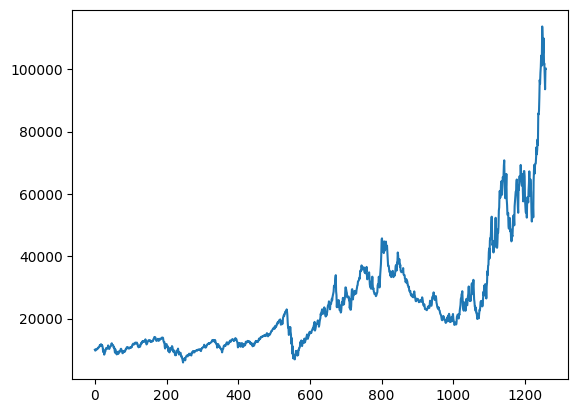

In [50]:
from matplotlib import pyplot as plt
plt.plot(bestSettings["portfolio"])